# Overhead (Multi parameter) 


This is the Notebook used to analyze whether any additional overhead is added by parameter control.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


<Figure size 400x300 with 0 Axes>

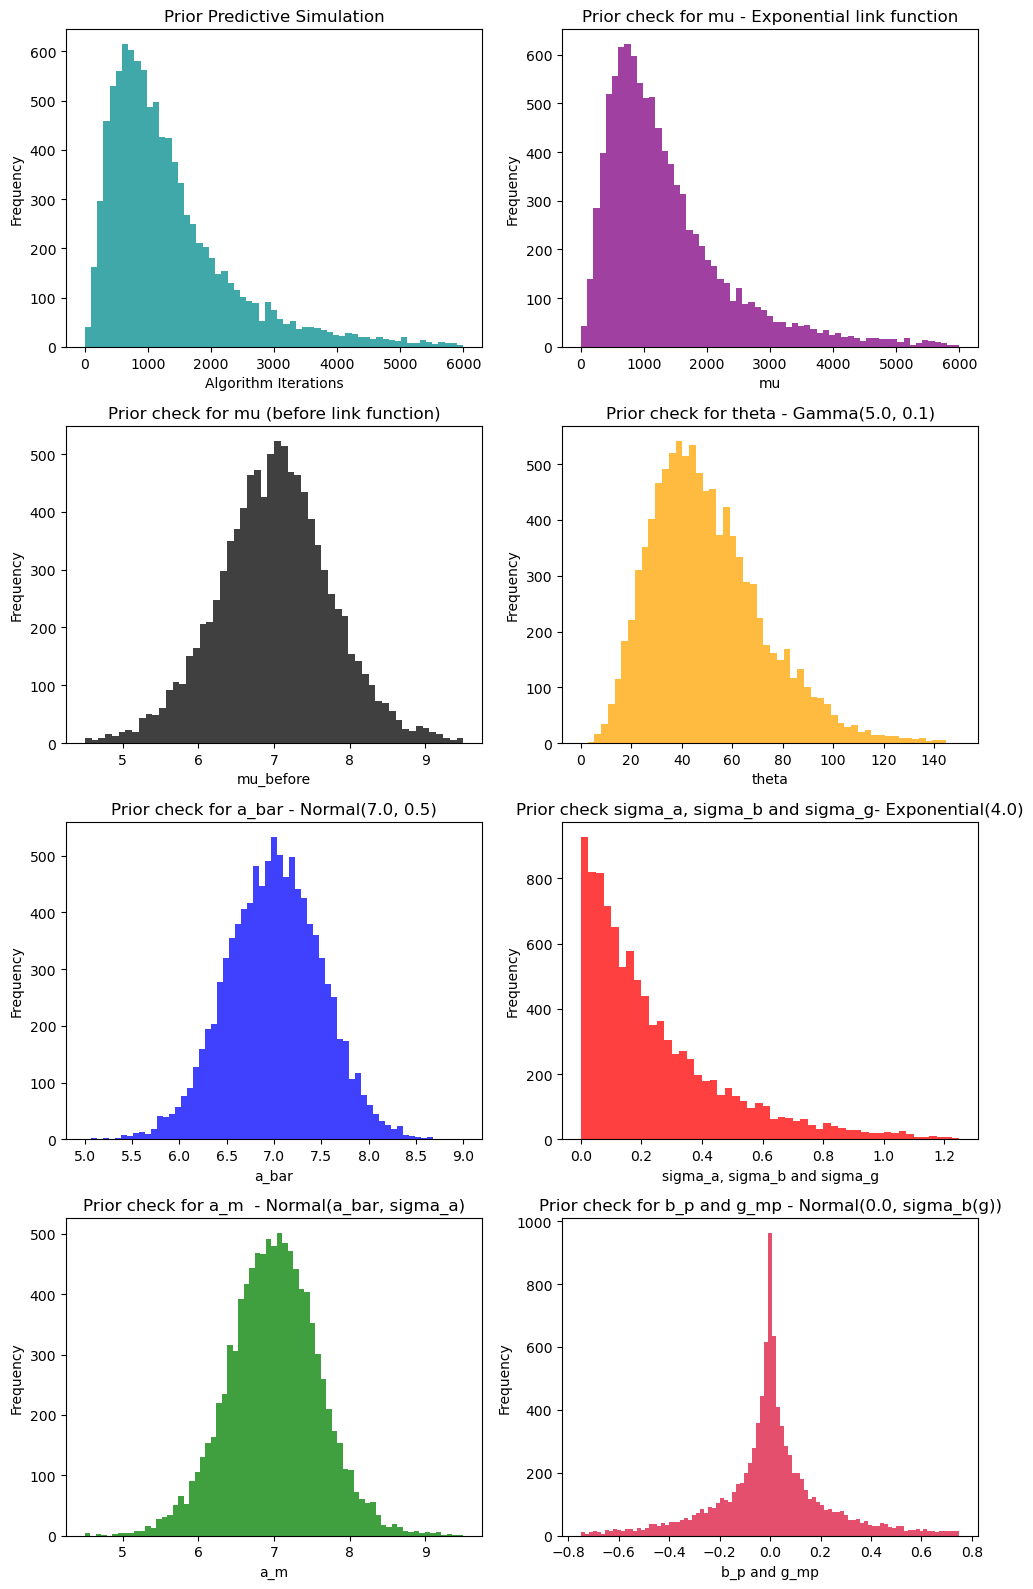

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (exp), from ln to exp
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p + g_mp))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=5.0, beta=0.1)
        
        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    # Use n and p as parameters for the negative binomial to sample observations
    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Prior Predictive Simulation', 'Algorithm Iterations',
                                     'darkcyan', bin_range=(0,6000))

    # Plot priors for the different parameters
    plots = [
        observation_plot,
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior check for mu - Exponential link function', 'mu', 'purple', bin_range=(0, 6000)),
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior check for mu (before link function)', 'mu_before', 'black', bin_range=(4.5, 9.5)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior check for theta - Gamma(5.0, 0.1)', 'theta', 'orange', bin_range=(0,150)),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior check for a_bar - Normal(7.0, 0.5)', 'a_bar', 'blue', bin_range=(5,9)),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior check sigma_a, sigma_b and sigma_g- Exponential(4.0)', 'sigma_a, sigma_b and sigma_g', 'red', bin_range=(0, 1.25)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior check for a_m  - Normal(a_bar, sigma_a)', 'a_m', 'green', bin_range=(4.5,9.5)),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior check for b_p and g_mp - Normal(0.0, sigma_b(g))', 'b_p and g_mp', 'crimson', bin_range=(-0.75, 0.75)),
        
    ]

    plot_histograms(plots, 4, 2, figsize=(10,16), save_img=True, prefix_name="overhead_single", output_folder="prior_checks/overhead_single")

perform_prior_check(4,4,4,7,0.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)


# Model specification

### Data Preperation


In [1]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../multi_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'AlgorithmIterations')

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


### Execute the Model

In [ ]:
with pm.Model() as model:
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Modules, Parameters and Interactions effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=66)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=1584)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)
    log_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (exp), from ln to exp
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b + log_g))
    
    # Negative Binomial likelihood with parameter n and p
    theta = pm.Gamma('theta', alpha=5.0, beta=0.1) # Dispersion/spread parameter
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=observation_matrix['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4, return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Sampling complete!")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "overhead_model_multi_parameter.nc")

# Data analysis 

### Generate summary object (without transformations)

In [12]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 2000)


trace = az.from_netcdf("../multi_parameter/overhead_model_multi_parameter.nc")
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta']
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)


### Replace numeric identifiers with descriptive identifiers

In [13]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean     sd  hdi_5.5%  \
b_p[Pop|TestInsertionProb]                          -0.344  0.017    -0.371   
b_p[TestChangeProb|TestInsertionProb]               -0.218  0.017    -0.245   
b_p[TestInsertProb|TestInsertionProb]               -0.211  0.017    -0.238   
b_p[ChangeParamProb|TestInsertionProb]              -0.207  0.017    -0.234   
b_p[ChromLen|TestInsertionProb]                     -0.204  0.017    -0.231   
b_p[RandPert|TestInsertionProb]                     -0.198  0.017    -0.225   
b_p[Crossover|TestInsertionProb]                    -0.197  0.017    -0.224   
b_p[Elite|TestInsertionProb]                        -0.196  0.017    -0.223   
b_p[TestDeleteProb|TestInsertionProb]               -0.192  0.017    -0.218   
b_p[StatemInsertProb|TestInsertionProb]             -0.191  0.017    -0.219   
b_p[TestInsertionProb|TourSize]                     -0.187  0.017    -0.216   
b_p[Pop|TestInsertProb]                             -0.185  0.017    -0.212   
b_p[ChromLen|Pop]                                   -0.176  0.017    -0.203   
b_p[Pop|StatemInsertProb]                           -0.176  0.017    -0.203   
b_p[Pop|TestDeleteProb]                             -0.173  0.017    -0.201   
b_p[Crossover|Pop]                                  -0.164  0.017    -0.191   
b_p[ChangeParamProb|Pop]                            -0.164  0.017    -0.191   
b_p[Elite|Pop]                                      -0.162  0.017    -0.188   
b_p[Pop|TourSize]                                   -0.158  0.017    -0.184   
b_p[Pop|TestChangeProb]                             -0.158  0.017    -0.185   
b_p[Pop|RandPert]                                   -0.143  0.017    -0.171   
b_p[StatemInsertProb|TestChangeProb]                -0.039  0.017    -0.065   
b_p[Crossover|TestChangeProb]                       -0.038  0.017    -0.065   
b_p[Crossover|TestDeleteProb]                       -0.036  0.017    -0.062   
b_p[StatemInsertProb|TestInsertProb]                -0.034  0.017    -0.062   
b_p[RandPert|TestDeleteProb]                        -0.033  0.017    -0.060   
b_p[TestChangeProb|TestInsertProb]                  -0.032  0.017    -0.060   
b_p[StatemInsertProb|TestDeleteProb]                -0.031  0.017    -0.058   
b_p[Elite|StatemInsertProb]                         -0.030  0.017    -0.057   
b_p[TestDeleteProb|TestInsertProb]                  -0.028  0.017    -0.054   
b_p[TestChangeProb|TestDeleteProb]                  -0.028  0.017    -0.054   
b_p[Crossover|TestInsertProb]                       -0.025  0.017    -0.053   
b_p[ChromLen|TestDeleteProb]                        -0.025  0.017    -0.052   
b_p[ChromLen|StatemInsertProb]                      -0.023  0.017    -0.050   
b_p[Elite|RandPert]                                 -0.022  0.017    -0.049   
b_p[ChangeParamProb|TestChangeProb]                 -0.022  0.017    -0.049   
b_p[RandPert|TestChangeProb]                        -0.021  0.017    -0.047   
b_p[Elite|TestInsertProb]                           -0.020  0.017    -0.047   
b_p[ChromLen|Crossover]                             -0.018  0.017    -0.045   
b_p[Crossover|RandPert]                             -0.018  0.017    -0.044   
b_p[Crossover|Elite]                                -0.018  0.017    -0.045   
b_p[RandPert|StatemInsertProb]                      -0.017  0.017    -0.045   
b_p[TestInsertProb|TourSize]                        -0.014  0.017    -0.041   
b_p[ChangeParamProb|TestDeleteProb]                 -0.011  0.017    -0.037   
b_p[ChromLen|TestChangeProb]                        -0.011  0.017    -0.038   
b_p[ChangeParamProb|Crossover]                      -0.010  0.017    -0.037   
b_p[StatemInsertProb|TourSize]                      -0.010  0.017    -0.036   
b_p[TestDeleteProb|TourSize]                        -0.010  0.017    -0.037   
b_p[Crossover|StatemInsertProb]                     -0.009  0.017    -0.035   
b_p[RandPert|TestInsertProb]                        -0.009  0.017    -0.036   
g_mp[config x ChangeParam

### Plot the prior distributions and their assosicated trace plots

(-3.0, 3.0)

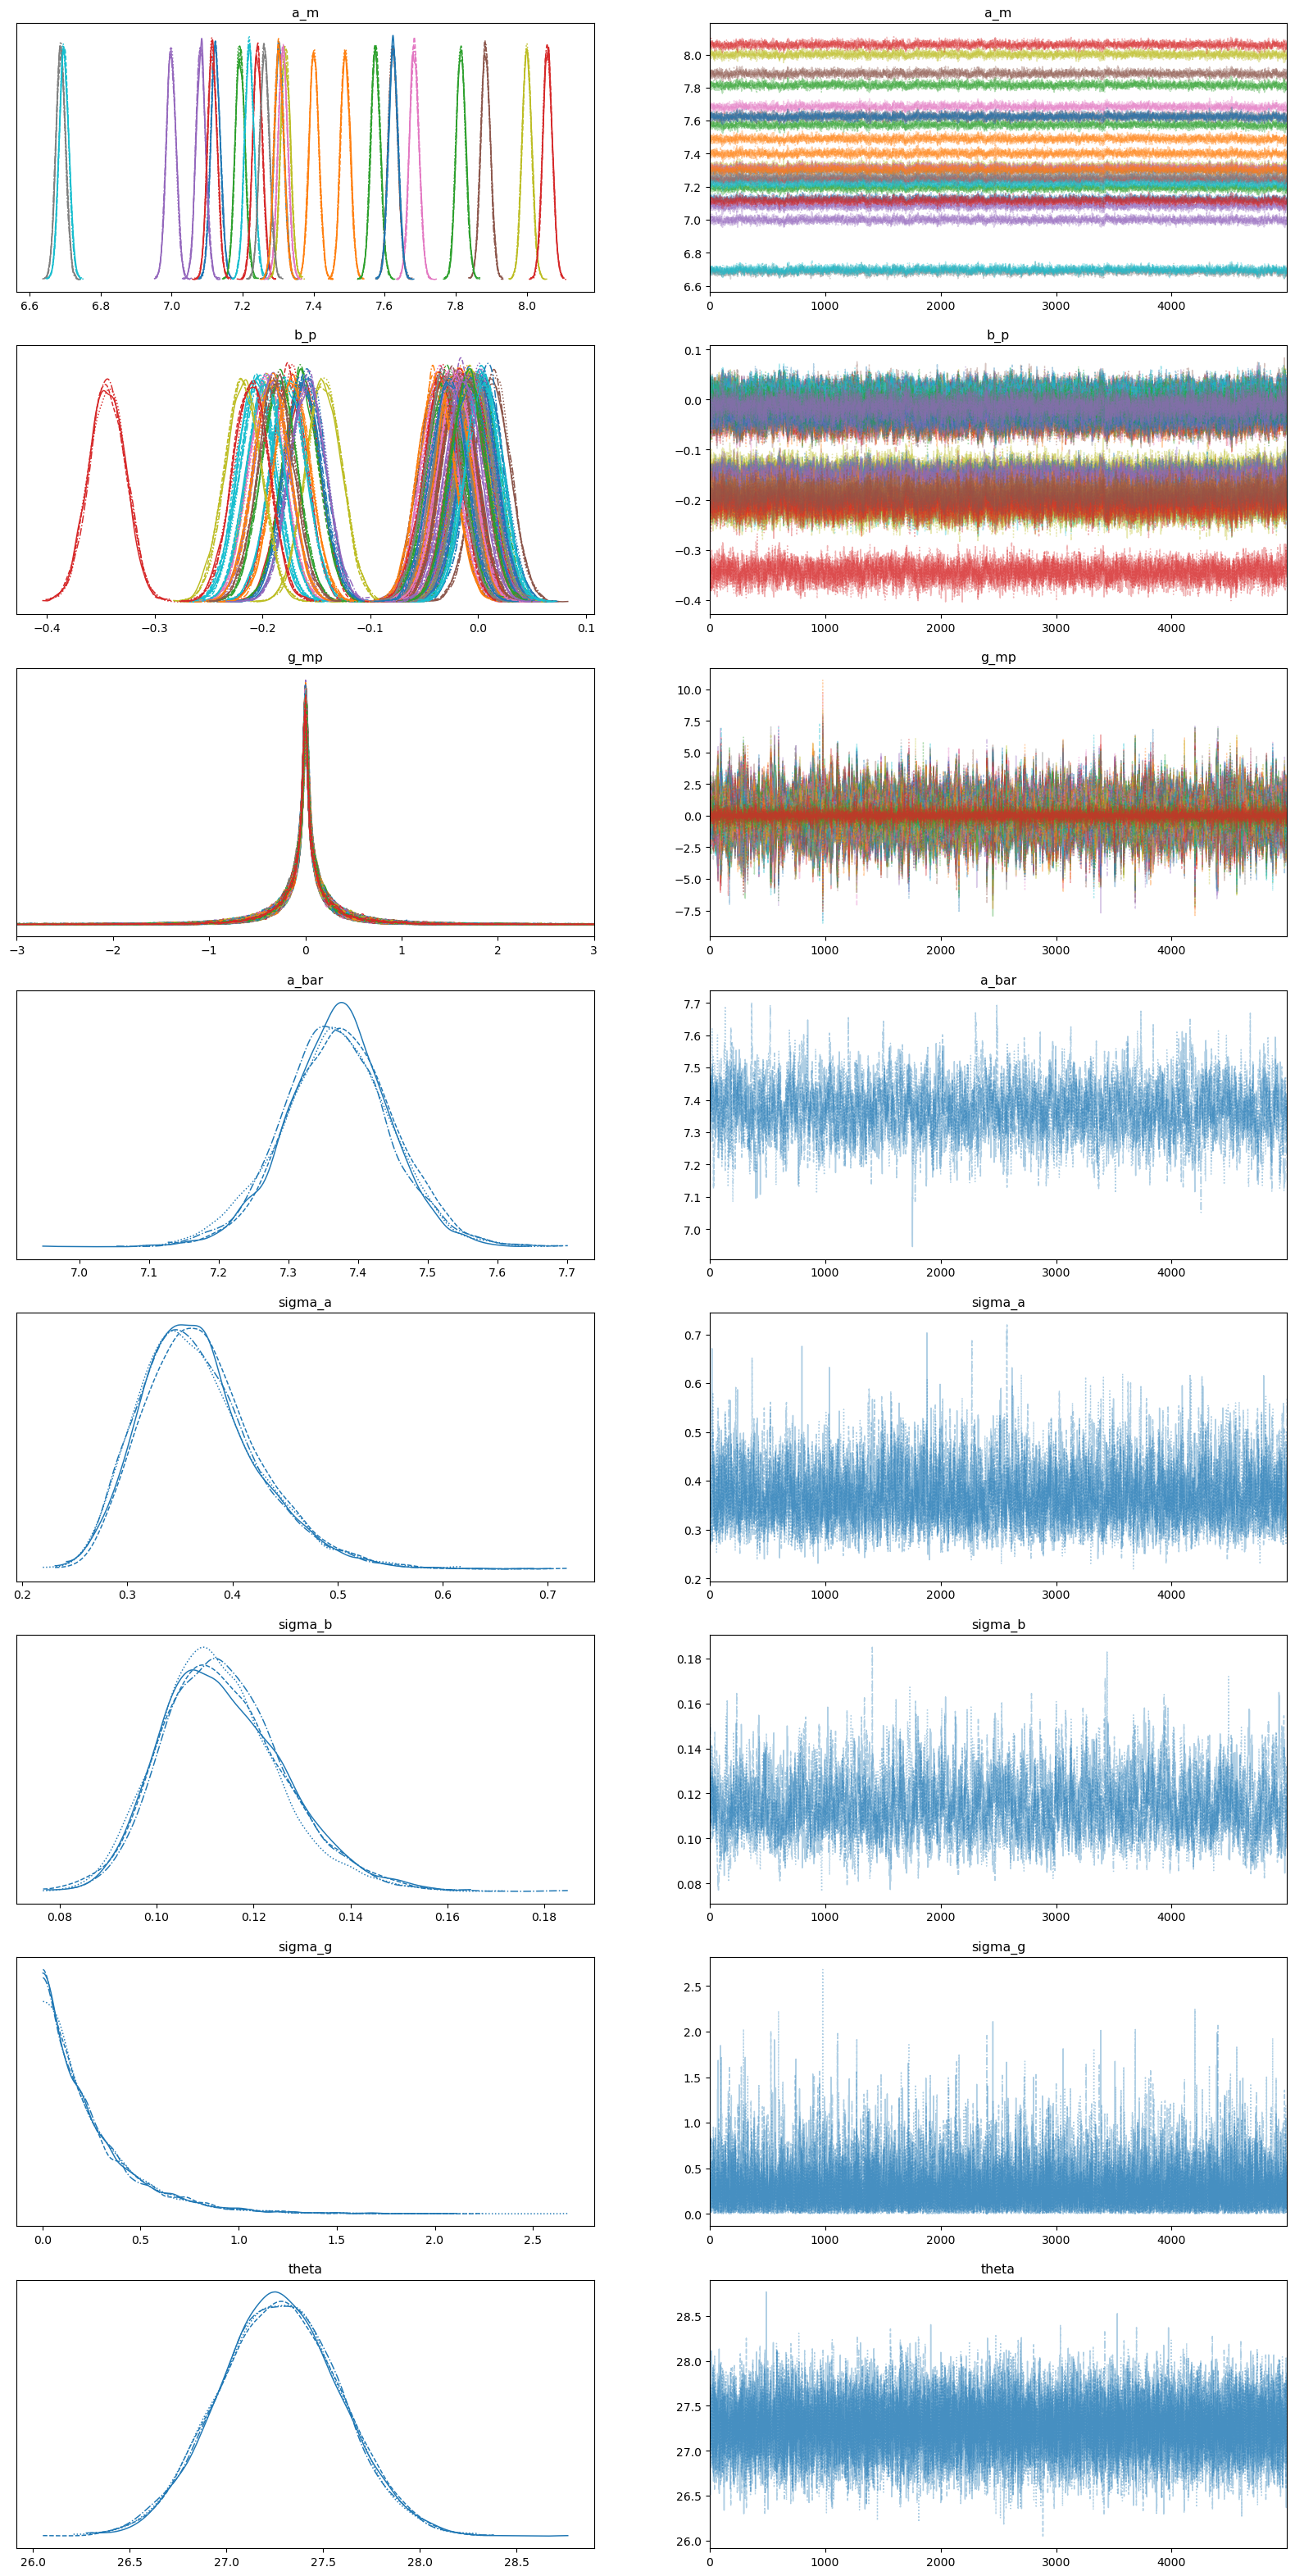

In [15]:
axes = az.plot_trace(idata, var_names=variable_list, figsize=(20, 40))

posterior_x_min = -3
posterior_x_max = 3

axes[2, 0].set_xlim([posterior_x_min, posterior_x_max])
#axes[2, 1].set_ylim([trace_y_min, trace_y_max])

### Transformed effects

In [2]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 2000) 

trace = az.from_netcdf("../multi_parameter/overhead_model_multi_parameter.nc")
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta']
transformations = {
    'a_m': log_to_exp,
    'b_p': log_to_exp,
    'g_mp': log_to_exp,
    'a_bar': log_to_exp,
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary_transformed = az.summary(idata_transformed, variable_list, hdi_prob=0.89)


In [3]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary_transformed, 'a_m', replacement=module_names)
update_table(summary_transformed, 'b_p', replacement=parameter_names)
update_table(summary_transformed, 'g_mp', replacement=interaction_names)

summary_transformed.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean       sd  \
sigma_b                                                0.114    0.013   
sigma_g                                                0.247    0.249   
sigma_a                                                0.368    0.056   
b_p[Pop|TestInsertionProb]                             0.709    0.012   
b_p[TestChangeProb|TestInsertionProb]                  0.804    0.014   
b_p[TestInsertProb|TestInsertionProb]                  0.810    0.014   
b_p[ChangeParamProb|TestInsertionProb]                 0.813    0.014   
b_p[ChromLen|TestInsertionProb]                        0.815    0.014   
b_p[Crossover|TestInsertionProb]                       0.821    0.014   
b_p[RandPert|TestInsertionProb]                        0.821    0.014   
b_p[Elite|TestInsertionProb]                           0.822    0.014   
b_p[StatemInsertProb|TestInsertionProb]                0.826    0.014   
b_p[TestDeleteProb|TestInsertionProb]                  0.826    0.014   
b_p[TestInsertionProb|TourSize]                        0.829    0.014   
b_p[Pop|TestInsertProb]                                0.831    0.014   
b_p[Pop|StatemInsertProb]                              0.839    0.014   
b_p[ChromLen|Pop]                                      0.839    0.014   
b_p[Pop|TestDeleteProb]                                0.841    0.014   
b_p[ChangeParamProb|Pop]                               0.849    0.014   
b_p[Crossover|Pop]                                     0.849    0.014   
b_p[Elite|Pop]                                         0.850    0.014   
b_p[Pop|TourSize]                                      0.854    0.014   
b_p[Pop|TestChangeProb]                                0.854    0.014   
b_p[Pop|RandPert]                                      0.867    0.015   
b_p[StatemInsertProb|TestChangeProb]                   0.962    0.016   
b_p[Crossover|TestChangeProb]                          0.963    0.016   
b_p[Crossover|TestDeleteProb]                          0.965    0.016   
b_p[StatemInsertProb|TestInsertProb]                   0.967    0.016   
b_p[RandPert|TestDeleteProb]                           0.968    0.016   
b_p[TestChangeProb|TestInsertProb]                     0.968    0.016   
b_p[StatemInsertProb|TestDeleteProb]                   0.969    0.016   
b_p[Elite|StatemInsertProb]                            0.971    0.016   
b_p[TestChangeProb|TestDeleteProb]                     0.973    0.016   
b_p[TestDeleteProb|TestInsertProb]                     0.973    0.016   
b_p[Crossover|TestInsertProb]                          0.975    0.016   
b_p[ChromLen|TestDeleteProb]                           0.976    0.016   
b_p[Elite|RandPert]                                    0.978    0.016   
b_p[ChangeParamProb|TestChangeProb]                    0.978    0.016   
b_p[ChromLen|StatemInsertProb]                         0.978    0.016   
b_p[RandPert|TestChangeProb]                           0.979    0.016   
b_p[Elite|TestInsertProb]                              0.980    0.016   
b_p[Crossover|Elite]                                   0.982    0.016   
b_p[ChromLen|Crossover]                                0.982    0.016   
b_p[RandPert|StatemInsertProb]                         0.983    0.016   
b_p[Crossover|RandPert]                                0.983    0.016   
b_p[TestInsertProb|TourSize]                           0.986    0.017   
b_p[ChromLen|TestChangeProb]                           0.989    0.017   
b_p[ChangeParamProb|TestDeleteProb]                    0.989    0.017   
b_p[StatemInsertProb|TourSize]                         0.990    0.016   
b_p[ChangeParamProb|Crossover]                         0.990    0.017   
b_p[RandPert|TestInsertProb]                           0.991    0.017   
b_p[TestDeleteProb|TourSize]                           0.991    0.016   
b_p[Crossover|StatemInsertProb]                        0.991    0.017   
b_p[RandPert|TourSize]                                 0.992    0.017   
b_p[Elite|TestDeleteProb]                

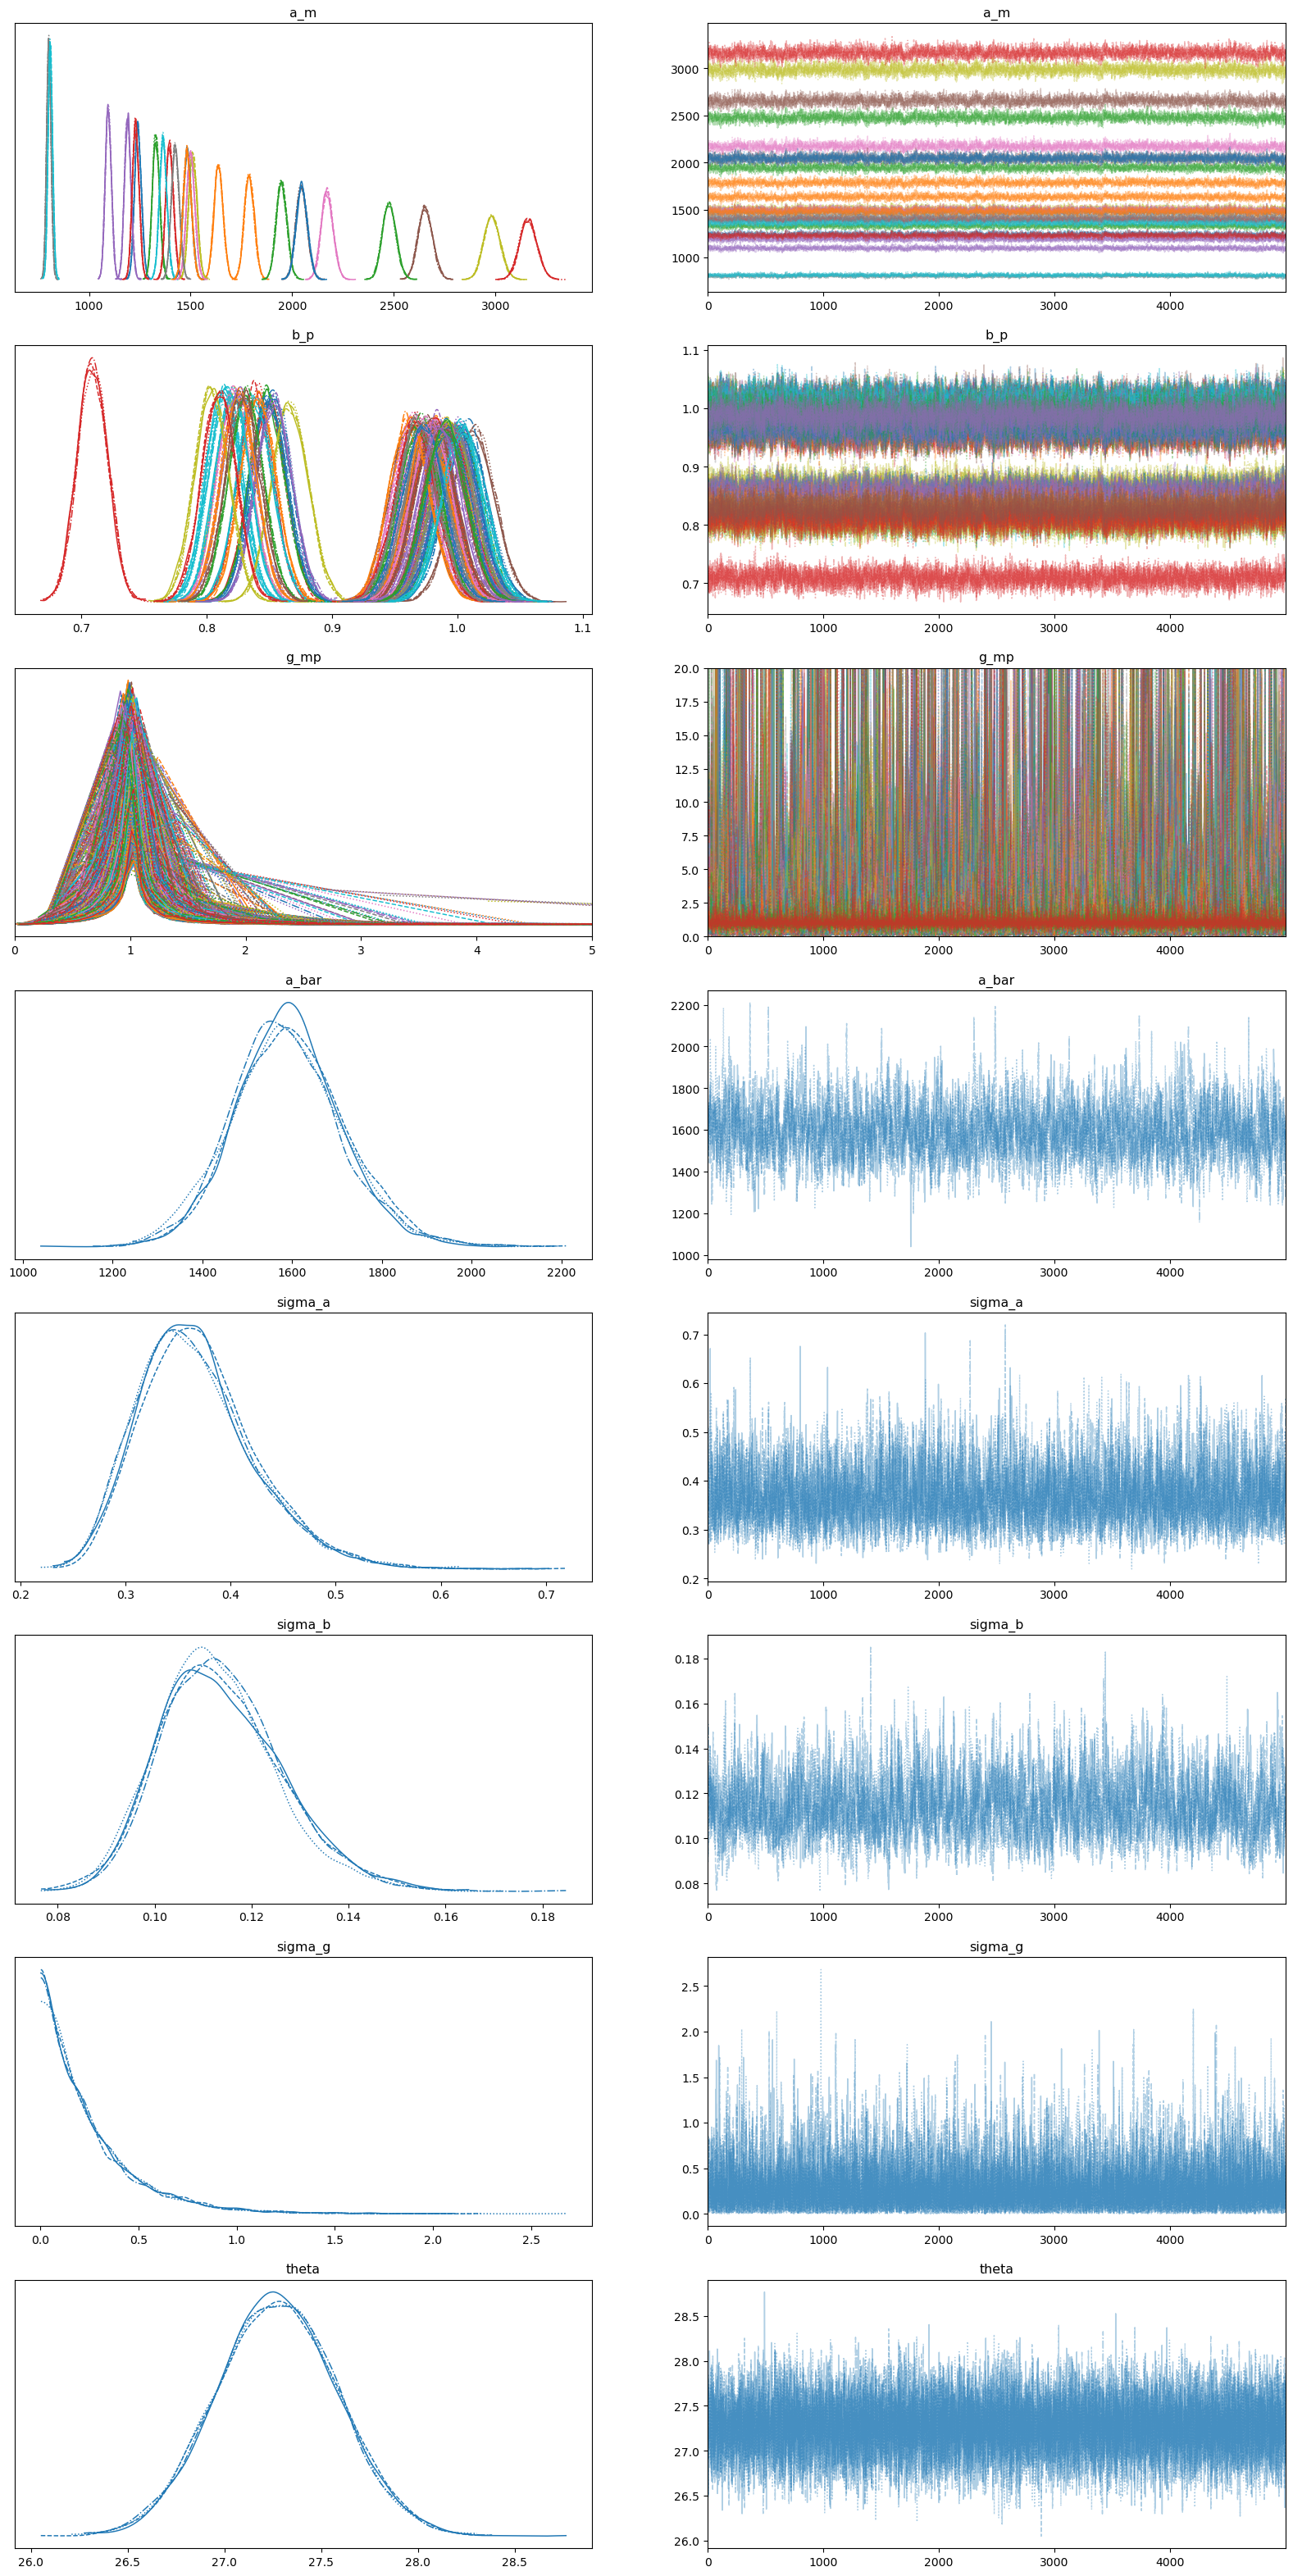

In [11]:
import matplotlib.pyplot as plt
axes = az.plot_trace(idata_transformed, var_names=variable_list, figsize=(20, 40))

trace_y_min = 0
trace_y_max = 20
posterior_x_min = 0
posterior_x_max = 5

axes[2, 0].set_xlim([posterior_x_min, posterior_x_max])
axes[2, 1].set_ylim([trace_y_min, trace_y_max])

plt.show()